In [1]:
# 前根收 ema 38 以下，此根收 ema 38 以上，且量大於前根 2x
# ! conda install -c conda-forge ta --yes

In [2]:
import requests
import pandas as pd
import ta
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import time

In [3]:
timezone = 8
endpoint = 'wss://stream.binance.com:9443/ws'
symbol = 'ethusdt'
symbol_C = symbol.upper()
interval = '15m'

# start epoch till now
start_time = 1641014900000
end_time = round(time.time() * 1000)
# end_time = 1672556207000

# step between timestamps in milliseconds
step = 60000 * 3600

In [4]:
def get_historical(symbol, interval, start_time, end_time, step):
    
    raw_df = pd.DataFrame()
    
    url = "https://api.binance.com/api/v3/klines"
    
    for timestamp in range(start_time, end_time, step):
        params = {"symbol": symbol_C,
                  "interval": interval,
                  "startTime": timestamp,
                  "endTime": timestamp + step}
        response = requests.get(url, params=params).json()
        out = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                               "Volume", "Close_Time", "Quote asset volume",
                                               "Number of trades", "Taker buy base asset volume",
                                               "Taker buy quote asset volume", "Ignore"])
        raw_df = pd.concat([raw_df, out], axis = 0)
    
    raw_df = raw_df[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']]
    convert_dict = {'Close_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
    raw_df = raw_df.astype(convert_dict)
    
    raw_df['Close_Time'] = pd.to_datetime(raw_df['Close_Time'], unit = 'ms')
    raw_df['Close_Time'] = raw_df['Close_Time'] + pd.Timedelta(hours=timezone)
    raw_df['Close_Time'] = raw_df['Close_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    raw_df = raw_df.reset_index(drop=True)
    
    return raw_df

In [5]:
raw_df = get_historical(symbol, interval, start_time, end_time, step)
print(raw_df)

                Close_Time     Open    Close     High      Low     Volume
0      2022-01-01 13:44:59  3750.68  3744.44  3765.27  3743.86  2412.6401
1      2022-01-01 13:59:59  3744.44  3735.61  3744.45  3728.60  1010.6714
2      2022-01-01 14:14:59  3735.60  3741.00  3742.67  3728.00  1625.3019
3      2022-01-01 14:29:59  3741.00  3727.65  3741.00  3726.00  1049.1158
4      2022-01-01 14:44:59  3727.74  3723.56  3731.32  3722.33  1024.5073
...                    ...      ...      ...      ...      ...        ...
43222  2023-03-27 20:29:59  1767.29  1763.25  1769.33  1762.02  4302.8973
43223  2023-03-27 20:44:59  1763.24  1758.71  1765.19  1758.38  4324.6014
43224  2023-03-27 20:59:59  1758.72  1756.10  1759.00  1752.49  5269.3450
43225  2023-03-27 21:14:59  1756.10  1754.45  1759.00  1750.63  4465.0949
43226  2023-03-27 21:29:59  1754.45  1755.39  1755.90  1752.04  1395.2619

[43227 rows x 6 columns]


In [6]:
df = raw_df.copy()

In [7]:
def indicators(df):

# ema
    for i in (8, 18, 38):
        df['ema_'+str(i)] = ta.trend.ema_indicator(df.Close, window=i)

# atr8
    df['atr'] = ta.volatility.average_true_range(df.High, df.Low, df.Close)
    
# rsi
    rsi_int = 14
    df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window = rsi_int).rsi()

# kd
    kd_int = 14
    d_int = 3
   
    kd_df = pd.DataFrame()
    kd_df[str(kd_int) + '-Low'] = df['Low'].rolling(kd_int).min()
    kd_df[str(kd_int) + '-High'] = df['High'].rolling(kd_int).max()
    df['slow_k'] = (df['Close'] - kd_df[str(kd_int) + '-Low'])*100/(kd_df[str(kd_int) + '-High'] - kd_df[str(kd_int) + '-Low'])
    df['slow_d'] = df['slow_k'].rolling(d_int).mean()
    
    return df

def check_cross(df):
    series = df['slow_k'] > df['slow_d']
    return series.diff() & series

In [8]:
indicators(df)
df['kd_cross'] = check_cross(df)
print(df)

                Close_Time     Open    Close     High      Low     Volume  \
0      2022-01-01 13:44:59  3750.68  3744.44  3765.27  3743.86  2412.6401   
1      2022-01-01 13:59:59  3744.44  3735.61  3744.45  3728.60  1010.6714   
2      2022-01-01 14:14:59  3735.60  3741.00  3742.67  3728.00  1625.3019   
3      2022-01-01 14:29:59  3741.00  3727.65  3741.00  3726.00  1049.1158   
4      2022-01-01 14:44:59  3727.74  3723.56  3731.32  3722.33  1024.5073   
...                    ...      ...      ...      ...      ...        ...   
43222  2023-03-27 20:29:59  1767.29  1763.25  1769.33  1762.02  4302.8973   
43223  2023-03-27 20:44:59  1763.24  1758.71  1765.19  1758.38  4324.6014   
43224  2023-03-27 20:59:59  1758.72  1756.10  1759.00  1752.49  5269.3450   
43225  2023-03-27 21:14:59  1756.10  1754.45  1759.00  1750.63  4465.0949   
43226  2023-03-27 21:29:59  1754.45  1755.39  1755.90  1752.04  1395.2619   

             ema_8       ema_18       ema_38       atr        rsi     slow_

In [9]:
def conditions(df):

    for index, row in df.iterrows():
        # c1
        df['c1'] = df['Close'].shift(1) < df['ema_38']
        
        df['c2'] = df['Close'] > df['ema_38']
        
        df['c3'] = df['Volume'] > df['Volume'].shift(1) * 2

        
    # 條件達成
    df['signal'] = False
    df.loc[df.c1 & df.c2 & df.c3, 'signal'] = True


    # 下一根進場
    df['open_entry'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'open_entry'] = True
#     print(df[df['Close_Time'].str.contains('2023-03-11 16')])
    
    return df

In [10]:
conditions(df)

,Close_Time,Open,Close,High,Low,Volume,ema_8,ema_18,ema_38,atr,rsi,slow_k,slow_d,kd_cross,c1,c2,c3,signal,open_entry
0,2022-01-01 13:44:59,3750.68,3744.44,3765.27,3743.86,2412.6401,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False,False
1,2022-01-01 13:59:59,3744.44,3735.61,3744.45,3728.60,1010.6714,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False,False
2,2022-01-01 14:14:59,3735.60,3741.00,3742.67,3728.00,1625.3019,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False,False
3,2022-01-01 14:29:59,3741.00,3727.65,3741.00,3726.00,1049.1158,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False,False
4,2022-01-01 14:44:59,3727.74,3723.56,3731.32,3722.33,1024.5073,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43222,2023-03-27 20:29:59,1767.29,1763.25,1769.33,1762.02,4302.8973,1764.598471,1762.573660,1762.015464,4.589700,52.604139,55.760662,70.763155,False,False,True,False,False,False
43223,2023-03-27 20:44:59,1763.24,1758.71,1765.19,1758.38,4324.6014,1763.289922,1762.166959,1761.845953,4.748293,44.481213,26.861871,54.899724,False,False,False,False,False,False
43224,2023-03-27 20:59:59,1758.72,1756.10,1759.00,1752.49,5269.3450,1761.692161,1761.528332,1761.551289,4.874129,40.599833,20.383964,34.335499,False,True,False,False,False,False
43225,2023-03-27 21:14:59,1756.10,1754.45,1759.00,1750.63,4465.0949,1760.082792,1760.783244,1761.187121,5.123834,38.323169,19.519673,22.255169,False,True,False,False,False,False


In [11]:
entry_df = conditions(df)

# 進出場

in_position = False
stop_loss = np.nan
close_val = entry_df['Close']
atr_val = entry_df['atr']
open_val = entry_df['Open']

for index, row in entry_df.iterrows():

    if index == 0:
        continue
    
    elif entry_df.at[index, 'open_entry'] == True:
   
        entry_df.at[index, 'entry_p'] = close_val.shift(1).at[index]
        entry_df.at[index, 'stop_loss'] = open_val.shift(1).at[index]
        entry_df.at[index, 'position'] = 'Buy'
        in_position = True
        stop_loss = entry_df.at[index, 'stop_loss']
    

    # 吃筍
    #-----------------------------重要-----------------------------
    # 若用 if 寫，則有可能入場馬上吃筍，若用 elif 則一個 iteration 只會執行一次
    elif in_position == True and entry_df.at[index, 'Close'] < stop_loss:
        entry_df.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan

    # set take profit
    elif (entry_df.at[index, 'High'] >= close_val.shift(1).at[index] + 20 * atr_val.shift(1).at[index]) and in_position == True:
        entry_df.at[index, 'position'] = 'Sell'
        in_position = False
        stop_loss = np.nan

entry_df.to_csv('entry_df.csv')
        
raw_entry_df = entry_df.copy()

# 過濾有訊號或事件發生的Ｋ線
entry_df = entry_df[(entry_df['open_entry'] == True) |
              (entry_df['signal'] == True) | 
              (entry_df['position'] == 'Buy') |
              (entry_df['position'] == 'Sell') |
              (entry_df['position'] == 'Stop')]


print(entry_df)


                Close_Time     Open    Close     High      Low     Volume  \
40     2022-01-01 23:44:59  3713.17  3734.67  3745.36  3712.09  5045.6743   
41     2022-01-01 23:59:59  3734.67  3725.30  3742.30  3718.46  2193.1382   
111    2022-01-02 17:29:59  3743.73  3756.12  3770.00  3741.03  2601.3266   
112    2022-01-02 17:44:59  3756.12  3760.96  3762.99  3756.10   945.2641   
117    2022-01-02 18:59:59  3746.28  3743.16  3746.75  3740.00   783.5354   
...                    ...      ...      ...      ...      ...        ...   
43166  2023-03-27 06:29:59  1772.64  1774.19  1779.22  1768.97  4542.9075   
43180  2023-03-27 09:59:59  1768.09  1763.31  1768.10  1762.97  3293.5912   
43210  2023-03-27 17:29:59  1754.69  1760.88  1765.00  1754.49  4289.4340   
43211  2023-03-27 17:44:59  1760.88  1761.88  1763.05  1759.52  4329.9868   
43225  2023-03-27 21:14:59  1756.10  1754.45  1759.00  1750.63  4465.0949   

             ema_8       ema_18       ema_38        atr  ...     slow_d  \


In [12]:
# 部位回測

pos_df = entry_df.copy()
pos_df = pos_df.reset_index(drop = True)
pos_df = pos_df[(pos_df['position'] == 'Buy') |
              (pos_df['position'] == 'Sell') |
              (pos_df['position'] == 'Stop')]

# 一次進場多少單位
pos_size = 1

col = ['Close_Time', 'Open', 'Close', 'High', 'Low', 'ema_8', 'ema_18', 'ema_38', 'atr', 'kd_cross', 'position','entry_p', 'stop_loss']
pos = pos_df[col]
pos = pos.reset_index(drop = True)


for index, row in pos.iterrows():
    
    current_pos = 0
    
    # 進場
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'size'] = pos_size
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場
        
        # 停利：達成條件時收盤價
        if pos.at[index, 'position'] == 'Sell':
#             pos.at[index, 'exit_p'] = pos.at[index, 'Close']
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Buy':
                    pos.at[index, 'exit_p'] = pos.at[i, 'Close'] + 20 * pos.at[i, 'atr']
                break

        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Buy':
                    pos.at[index, 'exit_p'] = pos.at[i, 'stop_loss']
                break

        # 計算每次出場部位大小（每次出場皆清倉）
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Buy':
                current_pos += pos.at[i, 'size']
                if i == 0:
                    pos.at[index, 'size'] = -current_pos
                else:
                    continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


# 計算部位價值
for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)


# 若最後一筆為 Buy，移除該單，迭代驗證
for index, row in pos.iloc[::-1].iterrows():
    if row['position'] == 'Buy':
        pos = pos.drop(index)
    else:
        break
        
print(pos)
pos.to_csv('pos.csv')


# 手續費、滑點、價差
fee = 0.05 / 100
amt_abs_sum = pos.amt.abs().sum()
ttl_fee = amt_abs_sum * fee

# 損益
leverage = 10
ttl_profit = -pos.amt.sum() - ttl_fee


# 計算進場最大部位來代表總進場成本，以計算報酬率
pos['consec_entry'] = (pos['position'] != pos['position'].shift()).cumsum()
group_consec = pos.groupby('consec_entry').apply(lambda x:x.loc[x['position'] == 'Buy', 'amt' ].sum())
max_entry = group_consec.max()

profit_per = "{:.2f}%".format(ttl_profit / (max_entry/leverage) * 100)

wins = pos['position'].str.count('Sell').sum()
loses = pos['position'].str.count('Stop').sum()
total_pos = pos['position']
win_rate = "{:.2f}%".format(wins / (wins + loses) * 100)

result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Max_Entry': [round(max_entry, 2)],
          'Profit_%': [profit_per],
          'Win_Rate': [win_rate]}


result_df = pd.DataFrame(result)

print(result_df)



              Close_Time     Open    Close     High      Low        ema_8  \
0    2022-01-01 23:59:59  3734.67  3725.30  3742.30  3718.46  3716.363967   
1    2022-01-02 17:44:59  3756.12  3760.96  3762.99  3756.10  3748.775081   
2    2022-01-02 18:59:59  3746.28  3743.16  3746.75  3740.00  3748.593746   
3    2022-01-02 20:59:59  3750.67  3753.95  3759.83  3750.67  3747.495461   
4    2022-01-04 03:59:59  3759.43  3738.40  3763.91  3738.26  3754.348510   
..                   ...      ...      ...      ...      ...          ...   
744  2023-03-26 06:29:59  1742.08  1738.91  1743.14  1738.59  1734.986356   
745  2023-03-27 06:29:59  1772.64  1774.19  1779.22  1768.97  1766.623376   
746  2023-03-27 09:59:59  1768.09  1763.31  1768.10  1762.97  1770.874836   
747  2023-03-27 17:44:59  1760.88  1761.88  1763.05  1759.52  1757.055413   
748  2023-03-27 21:14:59  1756.10  1754.45  1759.00  1750.63  1760.082792   

          ema_18       ema_38        atr  kd_cross position  entry_p  \
0  

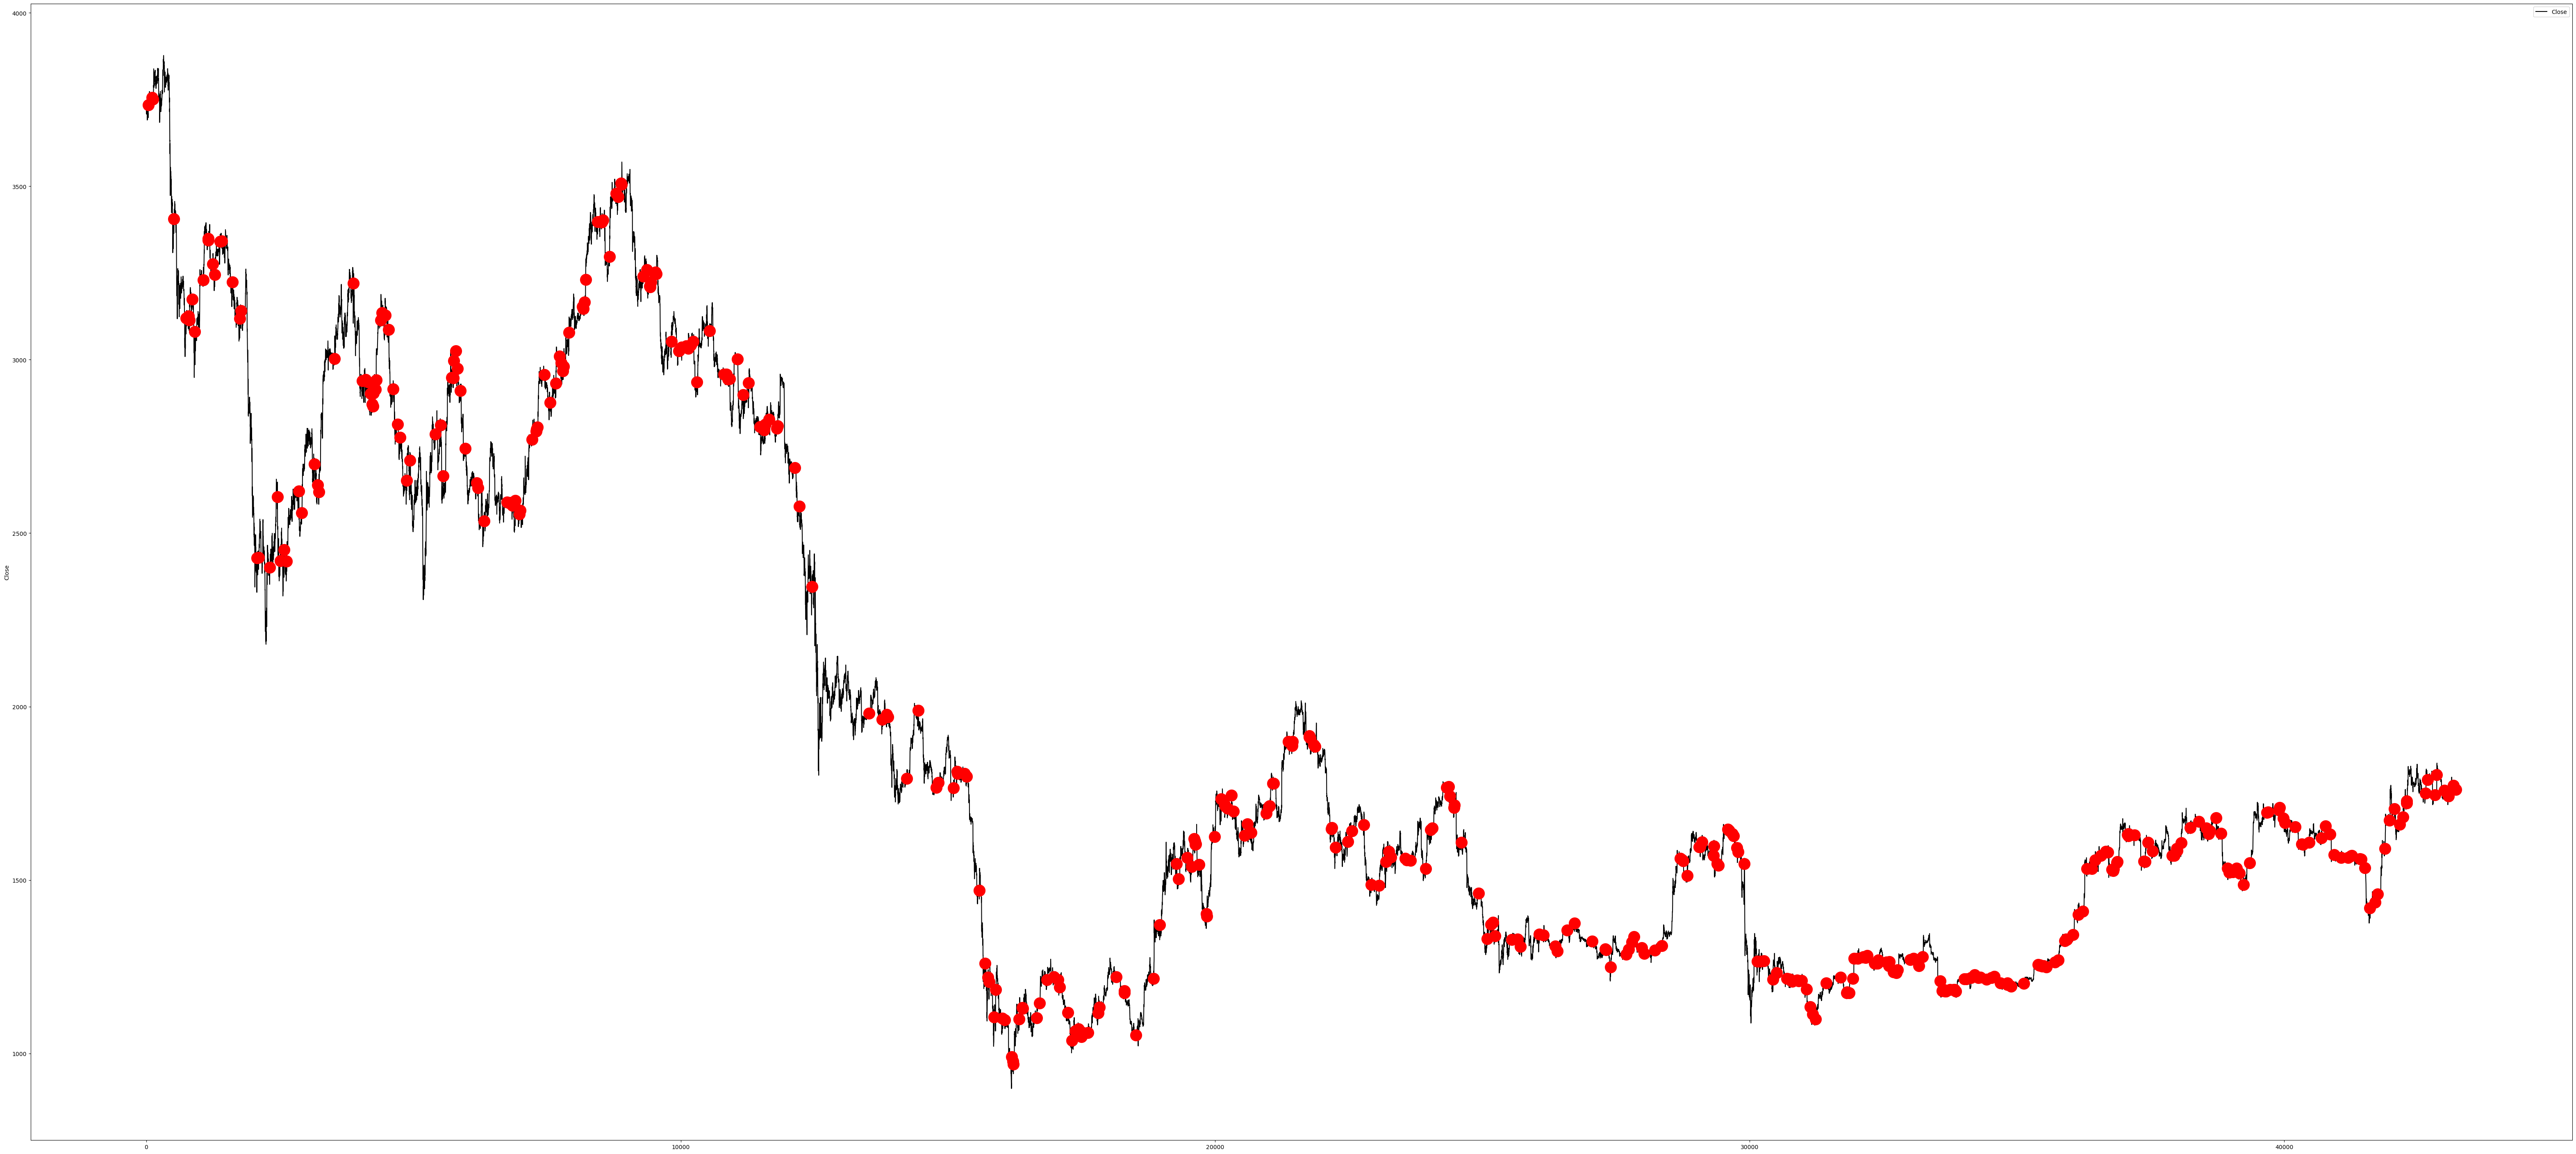

In [13]:
plt_df = raw_entry_df.copy()

plt.figure(figsize=(80, 36))
plt.ylabel('Close')
plt.plot(plt_df.Close, label = 'Close', c ='black')

i = 0
while i < len(plt_df):
    if pd.isna(plt_df.position[i]):
        i += 1
    elif plt_df.position[i] == 'Buy':
        j = i + 1
        while j < len(plt_df) and (pd.isna(plt_df.position[j]) or plt_df.position[j] == 'Buy'):
            j += 1
        if j < len(plt_df) and plt_df.position[j] == 'Sell':
            # Paint all previous 'Buy's green dot
            for k in range(i, j+1):
                plt.plot(k, plt_df.entry_p[k], 'go', label='_', markersize=20)
            i = j
        elif j < len(plt_df) and plt_df.position[j] == 'Stop':
            # Paint all previous 'Buy's red dot
            for k in range(i, j+1):
                plt.plot(k, plt_df.entry_p[k], 'ro', label='_', markersize=20)
            i = j + 1
        else:
            i = j
    else:
        i += 1

plt.legend()
plt.show()


# 之所以出現大量紅點，原因為：連續加倉會調整整個部位停利和停損，因此一些進倉部位會因為調高後的＂整個部位＂停損而出場，但該入場損益依舊為正
# 意思是該部位之停損已經高於許多前面部位之進場點位